# Imports, config and setting global variables

In [39]:
import os
import json
import numpy as np
import pandas as pd
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go


from tqdm import tqdm
tqdm.pandas()

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.datasets import fetch_california_housing, load_diabetes

In [40]:
import logging

if not os.path.exists('logs'):
    os.makedirs('logs')

LOGGING_FILE = os.path.join('logs', 'experiments.log')

logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s', 
                    datefmt='%Y-%m-%d %H:%M:%S', 
                    handlers=[logging.StreamHandler(), 
                              logging.FileHandler(LOGGING_FILE)])


In [41]:
N_SAMPLES = 1_000

MIN_LAMBDA_LOG_10 = -2
MAX_LAMBDA_LOG_10 = 2
NUM_LAMBDAS = 100

logging.info(f'Generating {N_SAMPLES} samples')
logging.info(f'''Using {NUM_LAMBDAS} lambdas equally spaced in log space from 10^({MIN_LAMBDA_LOG_10}) to 10^{MAX_LAMBDA_LOG_10}''')

LAMBDAS = np.logspace(MIN_LAMBDA_LOG_10, MAX_LAMBDA_LOG_10, NUM_LAMBDAS)

DGP_OPTIONS = ["3x_1 - 2x_2", "optim_slides", "california_housing", "diabetes", ]

DGP = DGP_OPTIONS[0]

# DGP1
MIN_THETA = -5
MAX_THETA = 5
N_VALUES_FOR_EACH_THETA = 50

# DGP 2
CORR_AMOUNT = 0.99

REPORT = {"MIN_LAMBDA_LOG_10": MIN_LAMBDA_LOG_10,
        "MAX_LAMBDA_LOG_10": MAX_LAMBDA_LOG_10,
        "NUM_LAMBDAS": NUM_LAMBDAS,
        "LAMBDAS": LAMBDAS,
        "DGP": DGP,
        "MIN_THETA": MIN_THETA,
        "MAX_THETA": MAX_THETA,
        "N_VALUES_FOR_EACH_THETA": N_VALUES_FOR_EACH_THETA}
if DGP == "optim_slides":
    REPORT["CORR_AMOUNT"] = CORR_AMOUNT

2024-12-09 03:17:51 - INFO - Generating 1000 samples
2024-12-09 03:17:51 - INFO - Using 100 lambdas equally spaced in log space from 10^(-2) to 10^2


## Helper functions

In [42]:
def empirical_risk(X, y, theta):
    # In the slides we don't divide by num samples, but it did not matter
    return np.mean((y - X @ theta)**2)


In [43]:
def filter_lambda_closest(df, target_lambda):
    """Filter the dataframe to the row with the lambda closest to the target_lambda
    
    We need this for replicating slide 327 (theta getting pulled to the origin)
    """
    
    closest_row = df.iloc[(df['lambda'] - target_lambda).abs().argsort()[:1]]
    return closest_row

In [44]:
def get_tuplet_structure(param, n_features):
    """Used for DGP from Optimization slides
    
    param = 0 -> identity matrix (no correlation)
    param = 1 -> all ones matrix (full correlation)
    """
    return np.array([[param**(abs(i-j)) for j in range(n_features)] for i in range(n_features)])


In [45]:
def create_plots(df, norms, dgp, reg):
    figs = {}
    for norm in norms:
        title = f'{dgp} | {reg} | {norm} of the coefficients'
        fig = px.line(df, x='lambda', y=[norm], title=title, labels={'value': 'Norm', 'variable': 'Lambda'}, markers=True)
        figs[norm] = {
            'base': fig,
            'log': go.Figure(fig).update_xaxes(type="log", title_text="Log-scaled Lambda"),
            'narrow': go.Figure(fig).update_xaxes(range=[0.01, 10], title_text="Lambda (0.01-10)"),
            'super_narrow': go.Figure(fig).update_xaxes(range=[0.01, 1], title_text="Lambda (0.01-1)")
        }
    combined_title = f'{dgp} | {reg} | L1 and L2 norms of the coefficients'
    combined_fig = px.line(
        df, x='lambda', y=norms, title=combined_title, labels={'value': 'Norm', 'variable': 'Norm Type'}, markers=True
    )
    figs['combined'] = {
        'base': combined_fig,
        'log': go.Figure(combined_fig).update_xaxes(type="log", title_text="Log-scaled Lambda"),
        'narrow': go.Figure(combined_fig).update_xaxes(range=[0.01, 10], title_text="Lambda (0.01-10)"),
        'super_narrow': go.Figure(combined_fig).update_xaxes(range=[0.01, 1], title_text="Lambda (0.01-1)")
    }
    return figs


# Defining Data Generating Processes 

- DGP from slide 327

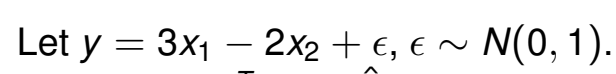

- DGP stolen from optimization lecture
  
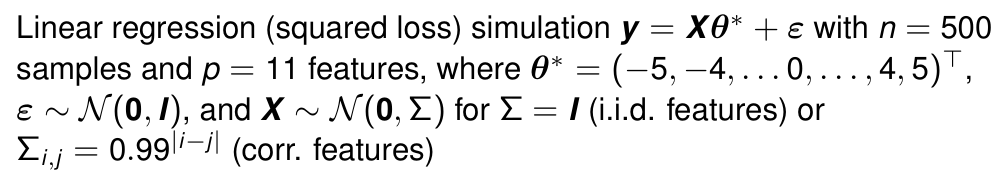



In [46]:
def data_generation_process(option, standardize=True):
    assert option in DGP_OPTIONS, f"Option {option} not in {DGP_OPTIONS}"
    
    match option:
        # (Slide 327/337) y = 3x_1 - 2x_2 + epsilon. epsilon ~ N(0, 1)
        case "3x_1 - 2x_2":
            X = np.random.rand(N_SAMPLES, 2)
            theta_true = np.array([3, -2]).reshape(-1, 1)
            y = X @ theta_true + np.random.randn(N_SAMPLES).reshape(-1,1)
            
        # Slide 1 from https://moodle.lmu.de/pluginfile.php/2688743/mod_folder/content/0/slides-multivar-first-order-12-comparison.pdf?forcedownload=1
        case "optim_slides":
            theta_true = np.arange(-5, 5+1, 1).reshape(-1, 1)
            N_FEATURES = len(theta_true)

            cov_matrix = get_tuplet_structure(CORR_AMOUNT, N_FEATURES)
            X = np.random.multivariate_normal(mean=np.zeros(N_FEATURES), cov=cov_matrix, size=N_SAMPLES) #for _ in range(N_SAMPLES)
            y = X @ theta_true + np.random.randn(N_SAMPLES).reshape(-1,1)
            
        case "california_housing":
            # https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.fetch_california_housing.html
            data = fetch_california_housing()
            X = data.data
            y = data.target.reshape(-1, 1)
            theta_true = None
    
        case "diabetes":
            # https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_diabetes.html
            data = load_diabetes()
            X = data.data
            y = data.target.reshape(-1, 1)
            theta_true = None
    
    if standardize:
        if option in ["california_housing", "diabetes"]:
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
    
    return X, y, theta_true

In [93]:
def get_thetas(X, y, lmbda, regularization="L1",add_intercept=False):
    """
    Computes the optimal thetas for the linear regression problem with L2 regularization.
    
    Args:
        X (np.ndarray): Data (intercept column will be added later)
        y (np.ndarray): Target
        lmbda (float): Regularization parameter
        regularization (str): L1 or L2 or elastic
        add_intercept (bool): If True, an intercept column will be added to X
    
    ToDO:
    - Here we also penalize the intercept term, I'm not sure if this is what we 
    want for our experiments. Need to figure this our (or preferably, try both)
    
    Note:
        - (This is unrelated to our goal but may be interesting): 
        performing QR decomposition before solving the normal equations did not
        provide any speedup even for large datasets. (We had just learned about
        this from Optimization course and I wanted to benchmark it)
    """
    assert regularization in ["L1", "L2", "elastic"], \
        f"Regularization {regularization} not supported"
    
    if add_intercept:
        X = np.c_[np.ones((n_samples, 1)), X]

    n_samples, n_features = X.shape

    if regularization == "L2":
        LHS = X.T.dot(X) + lmbda*np.eye(n_features)
        RHS = X.T.dot(y)
        
        solution = np.linalg.solve(LHS, RHS).reshape(-1)
    elif regularization == "L1":
        clf = Lasso(alpha=lmbda, fit_intercept=False)
        clf.fit(X, y)
        solution = clf.coef_
        
    elif regularization == "elastic":
        clf = ElasticNet(alpha=lmbda, fit_intercept=False)
        clf.fit(X, y)
        solution = clf.coef_
    
    return solution

# Contour plots

### Contours of the unregularized loss function

In [94]:
X, y, theta_true = data_generation_process("3x_1 - 2x_2")

In [101]:
def get_contour_plot(X, y, theta_true, lmbda=0, reg="L2", lambdas_pull=None):
    if lambdas_pull is None:
        lambdas_pull = [0.1, 1, 2.5, 5, 10, 20, 100]
    
    if X.shape[1] != 2:
        raise ValueError("Can't plot, skip this section")
    
    theta_1_vals = np.linspace(MIN_THETA, MAX_THETA, N_VALUES_FOR_EACH_THETA)
    theta_2_vals = np.linspace(MIN_THETA, MAX_THETA, N_VALUES_FOR_EACH_THETA)

    theta_pairs = np.array(np.meshgrid(theta_1_vals, theta_2_vals)).T.reshape(-1, 2)

    df_unreg_risk = pd.DataFrame(theta_pairs, columns=['theta_1', 'theta_2'])
    
    y_pred = X @ theta_pairs.T

    # y is being broadcasted here
    squared_residuals = (y - y_pred)**2
    square_residuals_mean = squared_residuals.mean(axis=0)
    
    if lmbda:
        if reg == "L2":
            square_residuals_mean += lmbda * np.linalg.norm(theta_pairs, axis=1)**2
        elif reg == "L1":
            square_residuals_mean += lmbda * np.linalg.norm(theta_pairs, ord=1, axis=1)
        elif reg == "elastic":
            square_residuals_mean += lmbda * np.linalg.norm(theta_pairs, ord=1, axis=1) + \
                lmbda * np.linalg.norm(theta_pairs, axis=1)**2
        else:
            raise ValueError(f"Unknown regularization type {reg}")
    df_unreg_risk["emp_risk"] = square_residuals_mean

    fig_cont_plot = go.Figure()

    fig_cont_plot.add_trace(go.Contour(
        x=df_unreg_risk["theta_1"],
        y=df_unreg_risk["theta_2"],
        z=df_unreg_risk["emp_risk"],
        colorscale='Viridis',
        showscale=False,
        showlegend=True
    ))

    fig_cont_plot.update_layout(
        title=f'Contour plot of empirical risk for lambda={lmbda} and reg={reg}',
        xaxis_title='theta_1',
        yaxis_title='theta_2'
    )

    # # add horizontal and vertical lines at 0s
    fig_cont_plot.add_shape(
        type='line',
        x0=MIN_THETA, y0=0, x1=MAX_THETA, y1=0,
        line=dict(color='white', width=1)
    )

    fig_cont_plot.add_shape(
        type='line',
        x0=0, y0=MIN_THETA, x1=0, y1=MAX_THETA,
        line=dict(color='white', width=1)
    )

    # add a point for the true theta
    fig_cont_plot.add_trace(go.Scatter(
        x=theta_true[0], y=theta_true[1],
        mode='markers',
        marker=dict(size=10, color='red'),
        name=f'theta_true = {theta_true}'
    ))
    
    for lmbda_pull in lambdas_pull:
        theta1_pull, theta2_pull = get_thetas(X, y, lmbda_pull, regularization=reg)
        fig_cont_plot.add_trace(go.Scatter(
            x=[theta1_pull], y=[theta2_pull],
            mode='markers',
            marker=dict(size=10, color='blue'),
            name=f'lambda = {lmbda_pull} | theta = [{theta1_pull:.2f}, {theta2_pull:.2f}]'
        ))
    fig_cont_plot.show()

In [104]:
get_contour_plot(X, y, theta_true, lmbda=10, reg="L2")

In [74]:
get_thetas(X, y, 0, regularization="L2", add_intercept=False)

array([ 3.09340067, -1.99375099])

# Gather all the code

In [34]:
config = {"MIN_LAMBDA_LOG_10": MIN_LAMBDA_LOG_10,
        "MAX_LAMBDA_LOG_10": MAX_LAMBDA_LOG_10,
        "NUM_LAMBDAS": NUM_LAMBDAS,
        "LAMBDAS": LAMBDAS,
        "DGP": DGP,
        "MIN_THETA": MIN_THETA,
        "MAX_THETA": MAX_THETA,
        "N_VALUES_FOR_EACH_THETA": N_VALUES_FOR_EACH_THETA,
        "REGULARIZATION": "L1"}
if DGP == "optim_slides":
    config["CORR_AMOUNT"] = CORR_AMOUNT
    


In [37]:
def do_all(config, reporting=True):
    dgp, reg = config["DGP"], config["REGULARIZATION"]
    if not os.path.exists('figures'):
        os.makedirs('figures')
    subfolder = os.path.join('figures', f"{dgp}_{reg}")
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    
    if reporting:    
        report = {}
        report["datetime"] = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
        for i, j in config.items():
            report[i] = j
        
    logging.info(f"DPG: {dgp} | Regularization: {reg}")
    
    X, y, theta_true = data_generation_process(dgp)
    logging.debug(f"\tStep 0: DPG done | X shape: {X.shape} | y shape: {y.shape}")
    
    print("ATT, theta_true", theta_true)
    theta_analytic = get_thetas(X, y, 0, regularization=reg, add_intercept=False)
    logging.debug(f"\tStep 1: Analytic solution done | Theta: {theta_analytic}")
    
    if dgp in ["3x_1 - 2x_2", "optim_slides"]:
        if np.linalg.norm(theta_analytic.reshape(-1,1) - theta_true) < 0.5:
            logging.warning(f'\tAnalytic solution is quite far {theta_analytic} != {theta_true}')
            
    theta_dict = {
        lmbda: get_thetas(X, y, lmbda, regularization=reg) \
            for lmbda in config["LAMBDAS"]
    }
    logging.debug(f"\tStep 2: Thetas for different lambdas done")
    
    # getting thetas for different lambdas
    df_thetas_per_lambda = pd.DataFrame(theta_dict).T
    
    df_thetas_per_lambda.reset_index(inplace=True)
    df_thetas_per_lambda.rename(columns={"index": "lambda"}, inplace=True)
    df_thetas_per_lambda.rename(columns={i: f"theta_{i}" for i in range(X.shape[1])}, inplace=True)

    coef_cols = [f"theta_{i}" for i in range(X.shape[1])]

    df_thetas_per_lambda["L1_norm"] = df_thetas_per_lambda[coef_cols].apply(lambda x: 
        np.linalg.norm(x, ord=1), axis=1)
    df_thetas_per_lambda["L2_norm"] = df_thetas_per_lambda[coef_cols].apply(lambda x: 
        np.linalg.norm(x, ord=2), axis=1)
    
    logging.debug(f"\tStep 3: Norms computed")

    plots = create_plots(df_thetas_per_lambda, ['L1_norm', 'L2_norm'], dgp, reg)

    # Accessing individual plots
    fig_rel_l1, fig_rel_l1_log_lambda, fig_rel_l1_narrow_x, fig_rel_l1_super_narrow_x = plots['L1_norm'].values()
    fig_rel_l2, fig_rel_l2_log_lambda, fig_rel_l2_narrow_x, fig_rel_l2_super_narrow_x = plots['L2_norm'].values()
    fig_combined, fig_combined_log, fig_combined_narrow, fig_combined_super_narrow = plots['combined'].values()

    
    logging.debug(f"\tStep 4: Plots done")
    # save all the figures
    all_figures = [
        fig_rel_l1, fig_rel_l1_log_lambda, fig_rel_l1_narrow_x, fig_rel_l1_super_narrow_x,
        fig_rel_l2, fig_rel_l2_log_lambda, fig_rel_l2_narrow_x, fig_rel_l2_super_narrow_x,
        fig_combined, fig_combined_log, fig_combined_narrow, fig_combined_super_narrow
    ]

    all_names = [
        "lambda_l1_norm_rel", "lambda_l1_norm_rel_log_lambda", "lambda_l1_norm_rel_narrow_x", "lambda_l1_norm_rel_super_narrow_x",
        "lambda_l2_norm_rel", "lambda_l2_norm_rel_log_lambda", "lambda_l2_norm_rel_narrow_x", "lambda_l2_norm_rel_super_narrow",
        "lambda_combined_norm_rel", "lambda_combined_norm_rel_log_lambda", "lambda_combined_norm_rel_narrow_x", "lambda_combined_norm_rel_super_narrow"
    ]

    # Save figures to HTML and update the report if reporting is enabled
    for fig, name in zip(all_figures, all_names):
        file_path = os.path.join(subfolder, f"{name}.html")
        fig.write_html(file_path)
        if reporting:
            report[f"{name}_file"] = file_path
        
    logging.debug(f"\tStep 5: Figures saved")
    
    logging.info(f"Done")
    if reporting:
        report["N_SAMPLES"] = X.shape[0]
        report["N_FEATURES"] = X.shape[1]
        report["THETA_TRUE"] = theta_true
    
    # make all numpy arrays into lists for json serialization
    for k, v in report.items():
        if isinstance(v, np.ndarray):
            report[k] = v.tolist()
            
    KEYS_TO_DROP = ["LAMBDAS"]        
    report = {k: v for k, v in report.items() if k not in KEYS_TO_DROP}
    
    with open(os.path.join(subfolder, "report.json"), 'w') as f:
        json.dump(report, f)

In [38]:
for dgp in tqdm(DGP_OPTIONS):
    for reg in ["L1", "L2", "ElasticNet"]:
        config["REGULARIZATION"] = reg
        config["DGP"] = dgp    
        do_all(config, reporting=True)

2024-12-09 03:02:39 - INFO - DPG: 3x_1 - 2x_2 | Regularization: L1
2024-12-09 03:02:39 - DEBUG - 	Step 0: DPG done | X shape: (1000, 2) | y shape: (1000, 1)
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.418e+02, tolerance: 2.407e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers im

ATT, theta_true [[ 3]
 [-2]]


2024-12-09 03:02:39 - DEBUG - 	Step 4: Plots done
2024-12-09 03:02:40 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:02:40 - INFO - Done
2024-12-09 03:02:40 - INFO - DPG: 3x_1 - 2x_2 | Regularization: L2
2024-12-09 03:02:40 - DEBUG - 	Step 0: DPG done | X shape: (1000, 2) | y shape: (1000, 1)
2024-12-09 03:02:40 - DEBUG - 	Step 1: Analytic solution done | Theta: [ 3.01517098 -2.0051396 ]
2024-12-09 03:02:40 - WARNING - 	Analytic solution is quite far [ 3.01517098 -2.0051396 ] != [[ 3]
 [-2]]
2024-12-09 03:02:40 - DEBUG - 	Step 2: Thetas for different lambdas done
2024-12-09 03:02:40 - DEBUG - 	Step 3: Norms computed


ATT, theta_true [[ 3]
 [-2]]


2024-12-09 03:02:40 - DEBUG - 	Step 4: Plots done
2024-12-09 03:02:41 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:02:41 - INFO - Done
2024-12-09 03:02:41 - INFO - DPG: 3x_1 - 2x_2 | Regularization: ElasticNet
2024-12-09 03:02:41 - DEBUG - 	Step 0: DPG done | X shape: (1000, 2) | y shape: (1000, 1)
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.426e+02, tole

ATT, theta_true [[ 3]
 [-2]]


2024-12-09 03:02:41 - DEBUG - 	Step 4: Plots done
2024-12-09 03:02:41 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:02:41 - INFO - Done
2024-12-09 03:02:41 - INFO - DPG: optim_slides | Regularization: L1
2024-12-09 03:02:41 - DEBUG - 	Step 0: DPG done | X shape: (1000, 11) | y shape: (1000, 1)
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.972e+02, tolerance:

ATT, theta_true [[-5]
 [-4]
 [-3]
 [-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]]


2024-12-09 03:02:42 - DEBUG - 	Step 3: Norms computed
2024-12-09 03:02:42 - DEBUG - 	Step 4: Plots done
2024-12-09 03:02:42 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:02:42 - INFO - Done
2024-12-09 03:02:42 - INFO - DPG: optim_slides | Regularization: L2
2024-12-09 03:02:42 - DEBUG - 	Step 0: DPG done | X shape: (1000, 11) | y shape: (1000, 1)
2024-12-09 03:02:42 - DEBUG - 	Step 1: Analytic solution done | Theta: [-5.1032726  -4.21943402 -2.46346528 -2.26368984 -1.03402114  0.30052028
  1.18026652  2.02963254  2.61040163  4.25272754  4.66746252]
2024-12-09 03:02:43 - DEBUG - 	Step 2: Thetas for different lambdas done
2024-12-09 03:02:43 - DEBUG - 	Step 3: Norms computed


ATT, theta_true [[-5]
 [-4]
 [-3]
 [-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]]


2024-12-09 03:02:43 - DEBUG - 	Step 4: Plots done
2024-12-09 03:02:44 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:02:44 - INFO - Done
2024-12-09 03:02:44 - INFO - DPG: optim_slides | Regularization: ElasticNet
2024-12-09 03:02:44 - DEBUG - 	Step 0: DPG done | X shape: (1000, 11) | y shape: (1000, 1)
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.918e+02, to

ATT, theta_true [[-5]
 [-4]
 [-3]
 [-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]]


2024-12-09 03:02:44 - DEBUG - 	Step 2: Thetas for different lambdas done
2024-12-09 03:02:44 - DEBUG - 	Step 3: Norms computed
2024-12-09 03:02:44 - DEBUG - 	Step 4: Plots done
2024-12-09 03:02:45 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:02:45 - INFO - Done
2024-12-09 03:02:45 - INFO - DPG: california_housing | Regularization: L1
2024-12-09 03:02:45 - DEBUG - 	Step 0: DPG done | X shape: (20640, 8) | y shape: (20640, 1)
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.



ATT, theta_true None


c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.237e+03, tolerance: 1.158e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

2024-12-09 03:02:48 - DEBUG - 	Step 1: Analytic solution done | Theta: [ 5.16737320e-01  1.57549122e-02 -1.86695321e-01  8.82907802e-01
  9.56256676e-06 -4.72467021e-03 -5.49399818e-02 -1.35735598e-02]
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+03, t

ATT, theta_true None


2024-12-09 03:04:26 - DEBUG - 	Step 4: Plots done
2024-12-09 03:04:27 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:04:27 - INFO - Done
2024-12-09 03:04:27 - INFO - DPG: california_housing | Regularization: ElasticNet
2024-12-09 03:04:27 - DEBUG - 	Step 0: DPG done | X shape: (20640, 8) | y shape: (20640, 1)
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.



ATT, theta_true None


c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.237e+03, tolerance: 1.158e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.

2024-12-09 03:04:31 - DEBUG - 	Step 1: Analytic solution done | Theta: [ 5.16737320e-01  1.57549122e-02 -1.86695321e-01  8.82907802e-01
  9.56256676e-06 -4.72467021e-03 -5.49399818e-02 -1.35735598e-02]
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.905e+03, t

ATT, theta_true None


2024-12-09 03:06:39 - DEBUG - 	Step 4: Plots done
2024-12-09 03:06:39 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:06:39 - INFO - Done
2024-12-09 03:06:39 - INFO - DPG: diabetes | Regularization: L2
2024-12-09 03:06:39 - DEBUG - 	Step 0: DPG done | X shape: (442, 10) | y shape: (442, 1)
2024-12-09 03:06:39 - DEBUG - 	Step 1: Analytic solution done | Theta: [ -10.0098663  -239.81564367  519.84592005  324.3846455  -792.17563855
  476.73902101  101.04326794  177.06323767  751.27369956   67.62669218]
2024-12-09 03:06:39 - DEBUG - 	Step 2: Thetas for different lambdas done
2024-12-09 03:06:39 - DEBUG - 	Step 3: Norms computed


ATT, theta_true None


2024-12-09 03:06:39 - DEBUG - 	Step 4: Plots done
2024-12-09 03:06:40 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:06:40 - INFO - Done
2024-12-09 03:06:40 - INFO - DPG: diabetes | Regularization: ElasticNet
2024-12-09 03:06:40 - DEBUG - 	Step 0: DPG done | X shape: (442, 10) | y shape: (442, 1)
c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.747e+06, toleranc

ATT, theta_true None


2024-12-09 03:06:41 - DEBUG - 	Step 4: Plots done
2024-12-09 03:06:41 - DEBUG - 	Step 5: Figures saved
2024-12-09 03:06:41 - INFO - Done


## Stupid problems require stupid solutions (taking screenshots of htmls of the plots)

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

def html_to_png(html_path, output_path, width=1200, height=800):
    # Set up the Selenium WebDriver
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument(f'--window-size={width},{height}')
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    try:
        # Load the HTML file
        driver.get(f"file://{html_path}")
        
        # Wait for the plot to fully render
        time.sleep(2)  # Adjust sleep time as needed for complex plots
        
        # Take a screenshot and save it as PNG
        driver.save_screenshot(output_path)
        print(f"Plot saved as PNG: {output_path}")
    finally:
        # Quit the browser
        driver.quit()

FOLDER = r"C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1"
if not os.path.exists(FOLDER):
    os.makedirs(os.path.join(FOLDER, "png"))

for file in tqdm(os.listdir(FOLDER)):
    if file.endswith(".html"):
        html_path = os.path.join(FOLDER, file)
        output_path = os.path.join(FOLDER, "png", file.replace(".html", ".png"))
        html_to_png(html_path, output_path)



  0%|          | 0/10 [00:00<?, ?it/s]2024-12-09 02:40:39 - INFO - ====== WebDriver manager ======
2024-12-09 02:40:40 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:40:40 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:40:40 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:40:40 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:40:40 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:40:41 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:40:41 - INFO - Driver [C:\Users\hayk_\.wdm\drivers\chromedriver\win64\131.0.6778.87\chromedriver-win32/chromedriver.exe] found in cache
2024-12-09 02:40:41 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Service cla

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l1_norm_rel.png


 10%|█         | 1/10 [00:09<01:26,  9.62s/it]2024-12-09 02:40:48 - INFO - ====== WebDriver manager ======
2024-12-09 02:40:49 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:40:49 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:40:50 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:40:54 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:40:54 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:40:55 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:40:55 - INFO - Driver [C:\Users\hayk_\.wdm\drivers\chromedriver\win64\131.0.6778.87\chromedriver-win32/chromedriver.exe] found in cache
2024-12-09 02:40:55 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Ser

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l1_norm_rel_log_lambda.png


 20%|██        | 2/10 [00:24<01:43, 12.97s/it]2024-12-09 02:41:04 - INFO - ====== WebDriver manager ======
2024-12-09 02:41:05 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:05 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:05 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:09 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:10 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:10 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:10 - INFO - Driver [C:\Users\hayk_\.wdm\drivers\chromedriver\win64\131.0.6778.87\chromedriver-win32/chromedriver.exe] found in cache
2024-12-09 02:41:10 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Ser

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l1_norm_rel_narrow_x.png


 30%|███       | 3/10 [00:38<01:33, 13.38s/it]2024-12-09 02:41:17 - INFO - ====== WebDriver manager ======
2024-12-09 02:41:19 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:19 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:20 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:26 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:26 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:26 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:26 - INFO - Driver [C:\Users\hayk_\.wdm\drivers\chromedriver\win64\131.0.6778.87\chromedriver-win32/chromedriver.exe] found in cache
2024-12-09 02:41:26 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Ser

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l1_norm_rel_super_narrow_x.png


 40%|████      | 4/10 [00:54<01:25, 14.30s/it]2024-12-09 02:41:33 - INFO - ====== WebDriver manager ======
2024-12-09 02:41:35 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:35 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:35 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:39 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:39 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:40 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:40 - INFO - Driver [C:\Users\hayk_\.wdm\drivers\chromedriver\win64\131.0.6778.87\chromedriver-win32/chromedriver.exe] found in cache
2024-12-09 02:41:40 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Ser

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l2_norm_rel.png


 50%|█████     | 5/10 [01:08<01:10, 14.05s/it]2024-12-09 02:41:47 - INFO - ====== WebDriver manager ======
2024-12-09 02:41:48 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:48 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:48 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:53 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:41:53 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:41:53 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:41:53 - INFO - Driver [C:\Users\hayk_\.wdm\drivers\chromedriver\win64\131.0.6778.87\chromedriver-win32/chromedriver.exe] found in cache
2024-12-09 02:41:53 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Ser

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l2_norm_rel_log_lambda.png


2024-12-09 02:41:59 - DEBUG - http://localhost:60616 "DELETE /session/8e179c98bfd0335ec2d89e556d54be3d HTTP/11" 200 0
2024-12-09 02:41:59 - DEBUG - Remote response: status=200 | data={"value":null} | headers=HTTPHeaderDict({'Content-Length': '14', 'Content-Type': 'application/json; charset=utf-8', 'cache-control': 'no-cache'})
2024-12-09 02:41:59 - DEBUG - Finished Request
 60%|██████    | 6/10 [01:22<00:57, 14.25s/it]2024-12-09 02:42:01 - INFO - ====== WebDriver manager ======
2024-12-09 02:42:03 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:42:03 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:42:04 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:42:08 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:42:08 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:42:0

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l2_norm_rel_narrow_x.png


 70%|███████   | 7/10 [01:36<00:42, 14.17s/it]2024-12-09 02:42:15 - INFO - ====== WebDriver manager ======
2024-12-09 02:42:17 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:42:17 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:42:17 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:42:21 - INFO - Get LATEST chromedriver version for google-chrome
2024-12-09 02:42:21 - DEBUG - Starting new HTTPS connection (1): googlechromelabs.github.io:443
2024-12-09 02:42:22 - DEBUG - https://googlechromelabs.github.io:443 "GET /chrome-for-testing/latest-patch-versions-per-build.json HTTP/11" 200 8613
2024-12-09 02:42:22 - INFO - Driver [C:\Users\hayk_\.wdm\drivers\chromedriver\win64\131.0.6778.87\chromedriver-win32/chromedriver.exe] found in cache
2024-12-09 02:42:22 - DEBUG - Skipping Selenium Manager; path to chrome driver specified in Ser

Plot saved as PNG: C:\Users\hayk_\OneDrive\Desktop\SL\regularization_lambda_t\figures\3x_1 - 2x_2_L1\png\lambda_l2_norm_rel_super_narrow.png


100%|██████████| 10/10 [01:50<00:00, 11.01s/it]


In [ ]:
theta_analytic = get_thetas(X, y, 0, regularization="L1",add_intercept=False)

if DGP in ["3x_1 - 2x_2", "optim_slides"]:
    assert np.linalg.norm(theta_analytic.reshape(-1,1) - theta_true) < 0.5, f'Analytic solution is quite far {theta_analytic} != {theta_true}'


c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\base.py:1473: UserWarning:

With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning:

Coordinate descent with no regularization may lead to unexpected results and is discouraged.

c:\Users\hayk_\.conda\envs\100\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.036e+03, tolerance: 2.356e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.



# Running the experiments

In [ ]:
theta_dict = {
    lmbda: get_thetas(X, y, lmbda) for lmbda in LAMBDAS
}

In [ ]:
X.shape

(10000, 2)

In [ ]:
df_thetas_per_lambda = pd.DataFrame(theta_dict).T

df_thetas_per_lambda.reset_index(inplace=True)


df_thetas_per_lambda.rename(columns={"index": "lambda"}, inplace=True)
df_thetas_per_lambda.rename(columns={i: f"theta_{i}" for i in range(X.shape[1])}, inplace=True)

coef_cols = [f"theta_{i}" for i in range(X.shape[1])]

df_thetas_per_lambda["L1_norm"] = df_thetas_per_lambda[coef_cols].apply(lambda x: 
    np.linalg.norm(x, ord=1), axis=1)
df_thetas_per_lambda["L2_norm"] = df_thetas_per_lambda[coef_cols].apply(lambda x: 
    np.linalg.norm(x, ord=2), axis=1)	


### Adding thetas to the contour plot

In [ ]:
# lambdas_do_display = [0.1, 1, 2.5, 5, 10, 20, 100, 1000]

# for lmbda in lambdas_do_display:
#     df_thetas_per_lambda_lmbda = filter_lambda_closest(df_thetas_per_lambda, lmbda)
#     fig_cont_plot.add_trace(go.Scatter(
#         x=df_thetas_per_lambda_lmbda['theta_1'],
#         y=df_thetas_per_lambda_lmbda['theta_2'],
#         mode='markers',
#         marker=dict(size=10, color='green'),
#         name=f'lambda={lmbda}'
#     ))
    
# fig_cont_plot.show()

# Plotting the results

In [68]:

fig_rel = px.scatter(df_thetas_per_lambda, x='lambda', y=['L2_norm'], 
                 title='L2 norm of the coefficients', 
                 labels={'value': 'Norm', 'variable': 'Lambda'},
                 log_x=True)
fig_rel.show()

In [559]:

fig_rel = px.scatter(df_thetas_per_lambda, x='lambda', y=["L1_norm", 'L2_norm'], 
                 title='L1 norm of the coefficients (huge range for lambdas)', 
                 labels={'value': 'Norm', 'variable': 'Lambda'},
                 log_x=True)
fig_rel.show()

### Relationship type

It doesn't make much sense to look into Spearman and Kendall Tao since the relationship would always be monotonic 

In [561]:
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import linregress, pearsonr

def evaluate_relationships(X, Y, relationships=["linear", "quadratic", "cubic", "log", "exp", "sqrt"]):
    """
    Evaluate the strength of various relationships between two features using R^2 scores.
    
    Returns:
        dict: A dictionary where keys are relationship names and values are R^2 scores.
    """
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
    results = {}
    
    def fit_and_score(transform_X=None, transform_Y=None, degree=None):
        transformed_X = transform_X(X) if transform_X else X
        transformed_Y = transform_Y(Y) if transform_Y else Y
                
        if degree:  # Polynomial fit
            coeffs = np.polyfit(transformed_X, transformed_Y, degree)
            Y_pred = np.polyval(coeffs, transformed_X)
            pearson, p_val = pearsonr(transformed_X, transformed_Y)

        else:  # Linear fit
            slope, intercept, pearson, p_val, _ = linregress(transformed_X, transformed_Y)
            Y_pred = slope * transformed_X + intercept

        return {"R2": r2_score(Y, Y_pred), "pearson": pearson, "p_val": p_val}


    transformations = {
        "linear": {"transform_X": None, "transform_Y": None, "degree": None},
        "quadratic": {"transform_X": None, "transform_Y": None, "degree": 2},
        "cubic": {"transform_X": None, "transform_Y": None, "degree": 3},
        "log": {"transform_X": np.log, "transform_Y": None, "degree": None},
        "exp": {"transform_X": None, "transform_Y": np.log, "degree": None},
        "sqrt": {"transform_X": np.sqrt, "transform_Y": None, "degree": None},
    }

    for relationship, params in transformations.items():
        results[relationship] = fit_and_score(**params)

    return results


In [562]:
pd.DataFrame(evaluate_relationships(df_thetas_per_lambda['lambda'], df_thetas_per_lambda['L2_norm'])).T

,R2,pearson,p_val
linear,0.377859,-0.614702,2.043658e-06
quadratic,0.552926,-0.614702,2.043658e-06
cubic,0.658914,-0.614702,2.043658e-06
log,0.691355,-0.831477,7.628534e-14
exp,-15.069481,-0.830148,9.065811e-14
sqrt,0.643383,-0.802112,2.529196e-12


In [563]:
fig_rel

# Conclusion

# Misc

In [564]:
import numpy as np
from scipy.optimize import minimize

# Generate synthetic data
np.random.seed(42)
n_samples, n_features = 100, 5
X = np.random.randn(n_samples, n_features)
true_beta = np.random.randn(n_features)
y = X @ true_beta + np.random.randn(n_samples) * 0.5  # Add some noise

# Ridge regression using constrained optimization
def ridge_constrained(beta, X, y):
    """
    Objective function for Ridge regression with constraints.
    
    Parameters:
        beta: Coefficients to optimize (vector of shape (n_features,))
        X: Design matrix (shape (n_samples, n_features))
        y: Target vector (shape (n_samples,))
        
    Returns:
        Loss value
    """
    residual = y - X @ beta
    return 0.5 * np.sum(residual ** 2)

# Constraint: norm(beta)^2 <= c
def constraint(beta, c):
    return c - np.sum(beta ** 2)

# Parameters
c_value = 10  # Constraint value for the norm
initial_beta = np.zeros(n_features)

# Define the constraint for the optimizer
constraints = {'type': 'ineq', 'fun': lambda beta: constraint(beta, c_value)}

# Minimize the objective function with constraints
result = minimize(
    ridge_constrained,
    initial_beta,
    args=(X, y),
    method='SLSQP',  # Sequential Least Squares Quadratic Programming
    constraints=constraints
)

# Extract the optimized coefficients
constrained_beta = result.x

# Print results
print("Optimized coefficients (constrained):", constrained_beta)
print("Norm of coefficients (squared):", np.sum(constrained_beta ** 2))
print("Constraint value (c):", c_value)


Optimized coefficients (constrained): [ 0.91395485  1.87915042 -1.35490377  0.58833439 -0.53157716]
Norm of coefficients (squared): 6.830995608349117
Constraint value (c): 10
